# Proper Scoring Rules and Model Calibration

When you have a probabilistic classifier, there are several ways to judge the performance of the model. These different performance measures can be grouped into the three broad categories below.

- improper scoring rules (eg any performance measure that is derived from the confusion matrix)
- quasi-proper scoring rules (eg area under the curve for the Receiver Operating Characteristic curve)
- proper scoring rules (eg Brier score, log loss, spherical payoff)

Denote $S(w, y)$ as a positively oriented function that can report the reward to a `forecaster`, where $w$ is the probabilistic forecast and $y$ is the actual outcome. When $S(q, q) \geq S(q, p)$ for all $p$ and $q$ ($p \neq q$), then $S$ is a proper scoring rule (the reward to the forecaster is maximized when $w$ is indeed $y$). With improper scoring rule, the probabilistic forecast is not used directly to compute the reward. Lastly, quasi-proper scoring rules is somewhere in between improper and proper scoring rules.

The expection value of a proper scoring rules is defined as follows.

$E(S) = UNC + REL - RES$, where

- uncertainy (UNC) measures the uncertainty in the outcomes fo the event,
- reliability (REL) measures how close the predicted probabilities are to the true probabilities, and
- resolution (RES) measures the difference between the conditional and expected probabilities.

The reliability component penalizes poorly calibrated models. In this notebook, we look at 3 proper scoring rules--Brier score, log loss and spherical payoff--and how they can be used to judge probabilistic classifiers and calibrated probabilistic classifiers.

## Load data

Let's import a dataset about students and whether they have conducted research. The indepent variables in X are the student's scores and peformance measures, and the dependent variable y is whether they have done research (y = 1) or not (y = 0).

In [1]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/selva86/datasets/master/Admission.csv'
Xy = pd.read_csv(url) \
    .drop(columns=['Chance of Admit ', 'Serial No.'])
    
X = Xy.drop(columns=['Research'])
y = Xy['Research']

X.shape, y.shape

((400, 6), (400,))

## Split into training, tuning and testing

The data is split into 3 equal parts for training, tuning and test. The training fold is used to fit the probabilistic classifier; the tuning fold is used to calibrate the model; the testing fold is used to test the model.

In [2]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=3, random_state=37, shuffle=True).split(X, y)

_, tr_idx = next(splitter)
_, tu_idx = next(splitter)
_, te_idx = next(splitter)

In [3]:
X_tr, X_tu, X_te = X.iloc[tr_idx], X.iloc[tu_idx], X.iloc[te_idx]
y_tr, y_tu, y_te = y.iloc[tr_idx], y.iloc[tu_idx], y.iloc[te_idx]

X_tr.shape, y_tr.shape, X_tu.shape, y_tu.shape, X_te.shape, y_te.shape

((134, 6), (134,), (133, 6), (133,), (133, 6), (133,))

In [4]:
y_tr.value_counts() / y_tr.value_counts().sum()

Research
1    0.544776
0    0.455224
Name: count, dtype: float64

In [5]:
y_tu.value_counts() / y_tu.value_counts().sum()

Research
1    0.548872
0    0.451128
Name: count, dtype: float64

In [6]:
y_te.value_counts() / y_te.value_counts().sum()

Research
1    0.548872
0    0.451128
Name: count, dtype: float64

## Logistic regression

Let's learn a logistic regression model `m1` and calibrate it `m2`.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

m1 = LogisticRegression(n_jobs=-1, random_state=37, solver='saga', max_iter=10_000)
m1.fit(X_tr, y_tr)

m2 = CalibratedClassifierCV(
    estimator=m1, 
    method='isotonic',
    cv=3, 
    n_jobs=-1
)
m2.fit(X_tu, y_tu)

CalibratedClassifierCV(cv=3,
                       estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                                    random_state=37,
                                                    solver='saga'),
                       method='isotonic', n_jobs=-1)

We can see that the logistic regression model does better than the null or calibrated ones.

In [8]:
p1 = (y_tr.value_counts() / y_tr.value_counts().sum()).sort_index().loc[1]

y_null = np.full(y_te.shape, p1)
y_pred = m1.predict_proba(X_te)[:,1]
y_cali = m2.predict_proba(X_te)[:,1]

In [9]:
from sklearn.metrics import brier_score_loss, log_loss

def get_spherical_payoff(y_t, y_p):
    n = y_p if y_t == 1 else 1 - y_p
    d = np.sqrt(y_p ** 2 + (1 - y_p) ** 2)
    return n / d

def spherical_payoff(y_true, y_pred):
    sp = [get_spherical_payoff(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)]
    sp = np.mean(sp)
    return sp

b = pd.Series([
    brier_score_loss(y_te, y_null),
    brier_score_loss(y_te, y_pred),
    brier_score_loss(y_te, y_cali)
], ['null', 'base', 'cali'])

l = pd.Series([
    log_loss(y_te, y_null),
    log_loss(y_te, y_pred),
    log_loss(y_te, y_cali)
], ['null', 'base', 'cali'])

s = pd.Series([
    spherical_payoff(y_te, y_null),
    spherical_payoff(y_te, y_pred),
    spherical_payoff(y_te, y_cali)
], ['null', 'base', 'cali'])

pd.DataFrame({
    'brier': b,
    'log_loss': l,
    'spherical_payoff': s
})

,brier,log_loss,spherical_payoff
null,0.247628,0.688396,0.710453
base,0.197336,0.573824,0.773217
cali,0.209509,0.607918,0.762035


You can see from the calibration plots below that the logistic regression model is already well calibrated. In fact, calibrating the logistic regression model makes it less well calibrated.

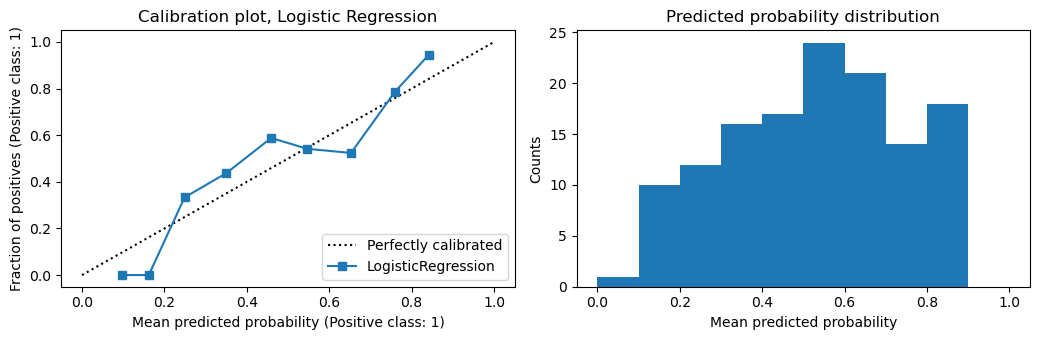

In [10]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

def plot_calibration(model, X_te, y_te, model_name):
    fig, ax = plt.subplots(1, 2, figsize=(10.5, 3.5))

    disp = CalibrationDisplay.from_estimator(
        model,
        X_te,
        y_te,
        n_bins=10,
        ax=ax[0],
    )

    ax[1].hist(
        disp.y_prob,
        range=(0, 1),
        bins=10
    )

    ax[0].set_title(f'Calibration plot, {model_name}')
    ax[1].set_title('Predicted probability distribution')
    ax[1].set_xlabel('Mean predicted probability')
    ax[1].set_ylabel('Counts')

    fig.tight_layout()

plot_calibration(m1, X_te, y_te, 'Logistic Regression')

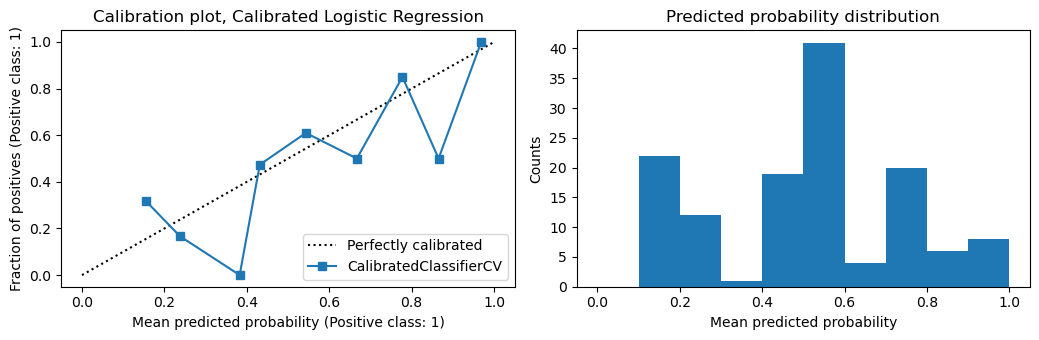

In [11]:
plot_calibration(m2, X_te, y_te, 'Calibrated Logistic Regression')

## Random forest

Here we learn a random forest `m1` and a calibrated one `m2`.

In [12]:
from sklearn.ensemble import RandomForestClassifier

m1 = RandomForestClassifier(n_jobs=-1, random_state=37, n_estimators=20)
m1.fit(X_tr, y_tr)

m2 = CalibratedClassifierCV(
    estimator=m1, 
    method='isotonic',
    cv=3, 
    n_jobs=-1
)
m2.fit(X_tu, y_tu)

CalibratedClassifierCV(cv=3,
                       estimator=RandomForestClassifier(n_estimators=20,
                                                        n_jobs=-1,
                                                        random_state=37),
                       method='isotonic', n_jobs=-1)

What we see for the random forest model is the same situation for the logistic regression model in terms of the proper scoring rules.

In [13]:
b = pd.Series([
    brier_score_loss(y_te, y_null),
    brier_score_loss(y_te, y_pred),
    brier_score_loss(y_te, y_cali)
], ['null', 'base', 'cali'])

l = pd.Series([
    log_loss(y_te, y_null),
    log_loss(y_te, y_pred),
    log_loss(y_te, y_cali)
], ['null', 'base', 'cali'])

s = pd.Series([
    spherical_payoff(y_te, y_null),
    spherical_payoff(y_te, y_pred),
    spherical_payoff(y_te, y_cali)
], ['null', 'base', 'cali'])

pd.DataFrame({
    'brier': b,
    'log_loss': l,
    'spherical_payoff': s
})

,brier,log_loss,spherical_payoff
null,0.247628,0.688396,0.710453
base,0.197336,0.573824,0.773217
cali,0.209509,0.607918,0.762035


Interestingly, random forest does need calibration. 

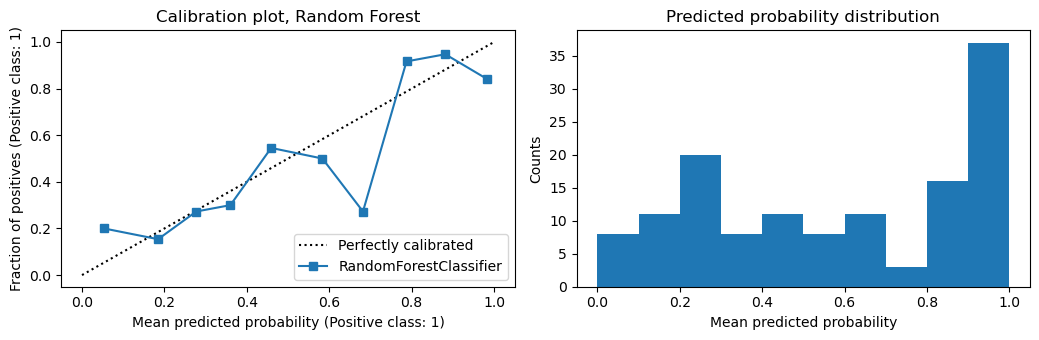

In [14]:
plot_calibration(m1, X_te, y_te, 'Random Forest')


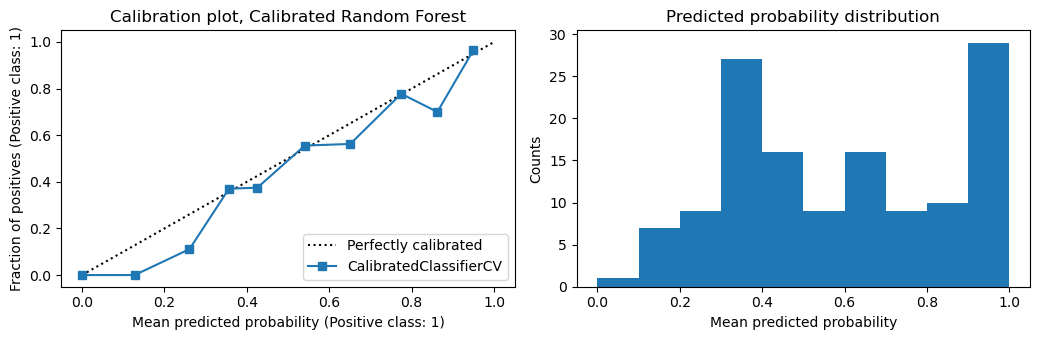

In [15]:
plot_calibration(m2, X_te, y_te, 'Calibrated Random Forest')